LA.norm(X2)=75467.84456309852
LA.norm(X2_rotate)=77301.49614067147
np.sum((X2_rotate != X2)*1)=784000
Calculating eigendecomposition...
Calculated eigendecomposition in 6.49 seconds.
Calculating Harmonic Alignment...
  Calculating diffusion coordinates...
Calculating PCA...
Calculated PCA in 0.39 seconds.
Calculating KNN search...
Calculated KNN search in 0.52 seconds.
Calculating affinities...
Calculated affinities in 0.11 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.88 seconds.
Calculating PCA...
Calculated PCA in 0.38 seconds.
Calculating KNN search...
Calculated KNN search in 0.50 seconds.
Calculating affinities...
Calculated affinities in 0.11 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.87 seconds.
  Calculated diffusion coordinates in 4.36 seconds.
  Calculating wavelets...
  Calculated wavelets in 6.66 seconds.
  Calculating transformed data...
    Calculating graph Laplacian...
Calculating PCA...

Text(0.5, 1.0, 'after alignment X2_rotate')

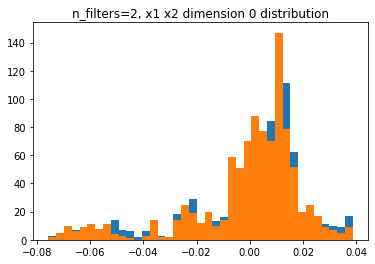

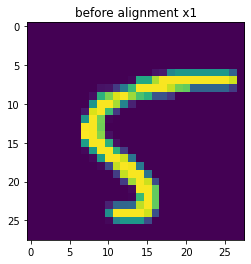

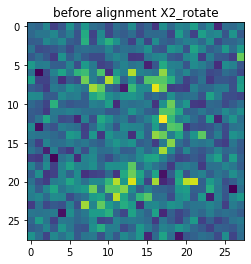

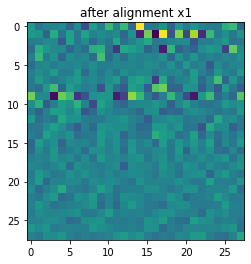

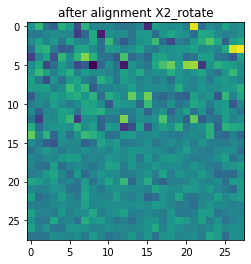

In [1]:
# we use this script in the paper to make the corruption experiment.
from sklearn import datasets, neighbors
from scipy import stats
import numpy as np
import harmonicalignment
import harmonicalignment.math

from shutil import copyfileobj
from six.moves import urllib
import os
import matplotlib.pyplot as plt

def knnclassifier(X, X_labels, Y, Y_labels, knn): #输出的是测试的准确率
    knn_op = neighbors.KNeighborsClassifier(knn)
    knn_op.fit(X, X_labels)
    return knn_op.score(Y, Y_labels)
def overlapRatio(x1,x2,title='before alignment'):
    plt.figure()
    _max=max(max(x1[:,0]),max(x2[:,0]))
    _min=min(min(x1[:,0]),min(x2[:,0]))
    bins = np.arange(_min,_max,(_max-_min)/40)
    hist1=plt.hist(x1[:,0],bins=bins) #np.arange(-2,2,0.1)
    # plt.figure()
    hist2=plt.hist(x2[:,0],bins=bins)
    plt.title(f"{title}, x1 x2 dimension 0 distribution")

    t = np.concatenate([np.expand_dims(hist1[0], axis=0) , np.expand_dims(hist2[0], axis=0)],axis=0)
    _overlapRatio = np.sum(np.min(t,axis=0)) / np.sum(hist1[0])
    return _overlapRatio

np.random.seed(42)
digits = datasets.fetch_openml("mnist_784")
labels = digits["target"]
# imgs = digits["data"]
imgs = np.asarray(digits["data"])

n_samples = 1000
n_features = 784
n_iters = 1
n_percentages = 3
n_wavelets = 4

colreplace_probs = np.linspace(0, 1, n_percentages) if n_percentages > 1 else [1]
# scale of wavelets(eg n_filters) to use 要使用的小波规模（例如n_filters）。
wavelet_scales = [2, 8, 16, 64]
# kernel params 内核参数
knn_1 = 20
decay_1 = 20
pca_1 = 100
knn_2 = knn_1
decay_2 = decay_1
pca_2 = pca_1
# Z = transformed
knn_transform = 10
decay_transform = 10
pca_transform = None
# diffusion time for final embedding 最终嵌入的扩散时间
diffusion_t = 1

output = np.zeros((n_percentages, n_iters, n_wavelets, 2))
# store metrics in here 在这里存储指标


# 在一系列的概率分布[0. , 0.5, 1. ]中选一个，使用这一个比例从总共的 784 的n_features的列 不进行旋转； 当pct=0的时候完全不正交旋转，当pct=1的时候所有行正交旋转。

p = 1 #for p in range(n_percentages): 
# build random matrix and replace prct of columns with I 构建随机矩阵，用I替换各列的prct
pct = colreplace_probs[p] # array([0. , 0.5, 1. ]) p=0,1,2
random_rotation = stats.ortho_group.rvs(n_features) # 返回一个随机的正交矩阵，从O(N) Haar分布（O(N)上唯一的均匀分布）抽取一个比例的列变成单位矩阵的对应列。
# random orthogonal rotation 随机正交旋转
colReplace = np.random.choice(
    n_features, np.floor(pct * n_features).astype(int), replace=False
)
random_rotation[:, colReplace] = np.eye(n_features)[:, colReplace] #只有 pct （百分值）的pixel的值没有被破坏。只有p%保留像素的损坏图像


iter_idx=0 # for iter_idx in range(n_iters):
#  sample two sets of digits from MNIST 从MNIST中抽取两组数字
sample_idx = np.random.choice(len(labels), n_samples * 2, replace=False)
X1_idx = sample_idx[:n_samples]
X2_idx = sample_idx[n_samples:]
#  slice the digits 分割数字
X1 = imgs[X1_idx, :]
X2 = imgs[X2_idx, :]
#  transform X2 转化X2
X2_rotate = X2 @ random_rotation.T # 这里的random_rotation 当pct=1的时候完全就是单位矩阵；当pct=10时候完全就是正交矩阵。当pct=（0，1）的时候是一个非正交矩阵。
import numpy.linalg as LA
print(f"LA.norm(X2)={LA.norm(X2)}")
print(f"LA.norm(X2_rotate)={LA.norm(X2_rotate)}")
print(f"np.sum((X2_rotate != X2)*1)={np.sum((X2_rotate != X2)*1)}")
X_combined = np.vstack([X1, X2_rotate])
U_combined, S_combined = harmonicalignment.math.diffusionCoordinates(
    X_combined, decay_1, knn_1, pca_1
) # 根据原始数据，构建graph，然后形成SVD，输出SVD的输出，也就是三个矩阵
# this is for evaluating unaligned data.  You can also plot this. 这是为评估不对齐的数据。 你也可以绘制这个。
#  slice the labels 切分标签
X1_labels = labels[X1_idx]
X2_labels = labels[X2_idx]
combined_labels = np.concatenate([X1_labels, X2_labels])
#  run pca and classify 运行PCA并且分类
DM_combined = U_combined @ np.diag(np.exp(-S_combined)) # 对于 SVD 的输出的乘积就是 PCA 的结果
beforeprct = knnclassifier(
    DM_combined[:n_samples, :],
    X1_labels,
    DM_combined[n_samples:, :],
    X2_labels,
    5,
) # 对于 PCA 的结果进行knn分类，前1000个数据作为训练，后面的
# for scale_idx in range(n_wavelets):
n_filters = 2 #n_filters = wavelet_scales[scale_idx]
align_op = harmonicalignment.HarmonicAlignment(
    n_filters,
    t=diffusion_t, # 1
    overlap=2,
    verbose=1,
    knn_X=knn_1, # 20
    knn_Y=knn_2, # 20
    knn_XY=knn_transform, # 10
    decay_X=decay_1, # 20
    decay_Y=decay_2, # 20
    decay_XY=decay_transform, # 10
    n_pca_X=pca_1, # 100
    n_pca_Y=pca_2, # 100
    n_pca_XY=pca_transform, # None
)
align_op.align(X1, X2_rotate)
Z = align_op.diffusion_map()
afterprct = knnclassifier(
    Z[:n_samples, :], X1_labels, Z[n_samples:, :], X2_labels, 5
)
xb1_aligned = Z[:n_samples, :]
xb2_aligned = Z[n_samples:, :]
print(f"beforeprct={beforeprct}")
print(f"afterprct={afterprct}")
_overlapRatio = overlapRatio(xb1_aligned,xb2_aligned,title=f'n_filters={n_filters}')
print(f"n_filters={n_filters}, overlapRatio={_overlapRatio}")
# output[p, iter_idx, scale_idx, 0] = beforeprct
# output[p, iter_idx, scale_idx, 1] = afterprct

# print(output)


# 展示align前后的图像
# align之前的图像
plt.figure()
plt.imshow(X1[0].reshape(28,-1))
plt.title("before alignment x1")

plt.figure()
plt.imshow(X2_rotate[0].reshape(28,-1))
plt.title("before alignment X2_rotate")

plt.figure()
plt.imshow(Z[0,:784].reshape(28,-1))
plt.title("after alignment x1")

plt.figure()
plt.imshow(Z[n_samples,:784].reshape(28,-1))
plt.title("after alignment X2_rotate")



n_filters=2, overlapRatio=0.8848484848484849


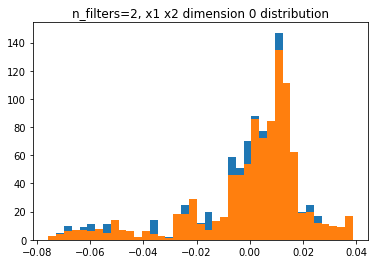

In [2]:
_overlapRatio = overlapRatio(xb2_aligned, xb1_aligned, title=f'n_filters={n_filters}')
print(f"n_filters={n_filters}, overlapRatio={_overlapRatio}")

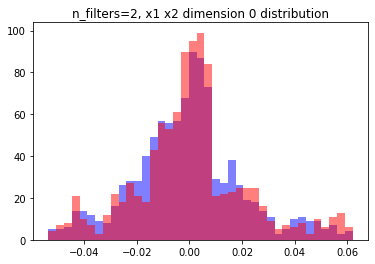

In [3]:
def overlapRatio(x1,x2,title='before alignment',nthFeature=0):
    plt.figure()
    a = x1[:,nthFeature]
    b = x2[:,nthFeature]
    _max=max(max(a),max(b))
    _min=min(min(a),min(b))
    bins = np.arange(_min,_max,(_max-_min)/40)
    hist1=plt.hist(a,bins=bins,fc=(0, 0, 1, 0.5)) #np.arange(-2,2,0.1)
    # plt.figure()
    hist2=plt.hist(b,bins=bins,fc=(1, 0, 0, 0.5))
    plt.title(f"{title}, x1 x2 dimension 0 distribution")

    t = np.concatenate([np.expand_dims(hist1[0], axis=0) , np.expand_dims(hist2[0], axis=0)],axis=0)
    _overlapRatio = np.sum(np.min(t,axis=0)) / np.sum(hist1[0])
    return _overlapRatio
_overlapRatio = overlapRatio(xb1_aligned,xb2_aligned,title=f'n_filters={n_filters}',nthFeature=2)

In [5]:
X1.shape

(1000, 784)

Text(0.5, 1.0, 'x1x2 aligned ; n_filters=2')

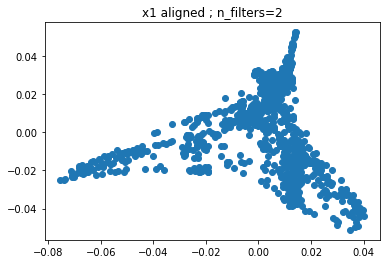

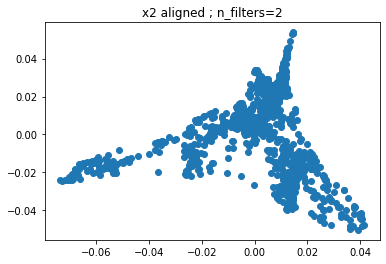

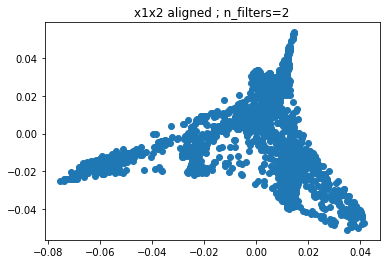

In [4]:

# 分别作图
plt.figure()
plt.scatter(xb1_aligned[:,0],xb1_aligned[:,1])
plt.title(f'x1 aligned ; n_filters={n_filters}')
plt.figure()
plt.scatter(xb2_aligned[:,0],xb2_aligned[:,1])
plt.title(f'x2 aligned ; n_filters={n_filters}')
plt.figure()
plt.scatter(Z[:,0],Z[:,1])
plt.title(f'x1x2 aligned ; n_filters={n_filters}')
# 发现效果非常差，因为原始数据是瑞士卷的数据的原始版x1和放大版x2
# 但是我得到的xb1_aligned 和 xb2_aligned 看到的效果是完全不重合


In [26]:
list(X1_labels)

['5',
 '7',
 '5',
 '8',
 '6',
 '7',
 '5',
 '4',
 '6',
 '1',
 '0',
 '4',
 '6',
 '6',
 '7',
 '7',
 '1',
 '9',
 '2',
 '1',
 '8',
 '3',
 '3',
 '9',
 '4',
 '1',
 '0',
 '4',
 '2',
 '0',
 '7',
 '1',
 '8',
 '7',
 '0',
 '1',
 '8',
 '0',
 '4',
 '6',
 '4',
 '4',
 '0',
 '5',
 '7',
 '1',
 '1',
 '1',
 '0',
 '8',
 '5',
 '8',
 '8',
 '1',
 '0',
 '8',
 '2',
 '9',
 '5',
 '9',
 '8',
 '0',
 '7',
 '4',
 '6',
 '9',
 '9',
 '5',
 '8',
 '1',
 '8',
 '5',
 '0',
 '7',
 '2',
 '6',
 '5',
 '5',
 '6',
 '9',
 '3',
 '1',
 '4',
 '9',
 '6',
 '4',
 '8',
 '1',
 '5',
 '9',
 '8',
 '8',
 '4',
 '0',
 '7',
 '9',
 '6',
 '5',
 '4',
 '8',
 '9',
 '9',
 '7',
 '3',
 '9',
 '8',
 '3',
 '6',
 '2',
 '0',
 '2',
 '8',
 '4',
 '1',
 '7',
 '6',
 '8',
 '0',
 '8',
 '6',
 '8',
 '6',
 '9',
 '2',
 '4',
 '4',
 '4',
 '8',
 '6',
 '9',
 '8',
 '6',
 '4',
 '0',
 '6',
 '2',
 '1',
 '6',
 '1',
 '3',
 '6',
 '1',
 '1',
 '5',
 '3',
 '6',
 '9',
 '4',
 '2',
 '1',
 '8',
 '6',
 '1',
 '6',
 '3',
 '6',
 '9',
 '0',
 '9',
 '7',
 '9',
 '2',
 '1',
 '9',
 '7',
 '6',
 '9'

In [25]:
X2_labels

8632     2
26753    0
41940    6
22922    2
22902    9
        ..
37647    0
68582    4
66681    3
67899    1
60163    4
Name: class, Length: 1000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/2922630334.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={40} t=auto",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


array([[ 0.01536801,  0.00928324],
       [-0.00268528,  0.00950349],
       [ 0.00915065, -0.00737539],
       ...,
       [ 0.02059262, -0.01241105],
       [-0.01091594, -0.02352936],
       [-0.00436701,  0.02441382]])

<Figure size 432x288 with 0 Axes>

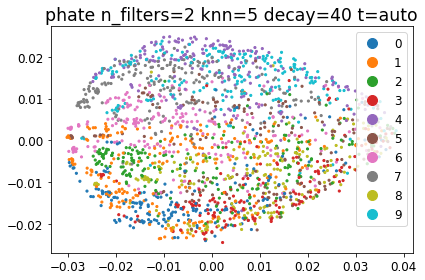

In [29]:
import phate
def show(X,labels,title=''):
    plt.figure()
    phate_operator = phate.PHATE(verbose=0)
    tree_phate = phate_operator.fit_transform(X)
    phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={40} t=auto",c=labels)
    return tree_phate
show(Z,list(X1_labels)+list(X2_labels),title=f'phate n_filters={n_filters}')

/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/2922630334.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={40} t=auto",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


array([[-2.80776977e-03,  9.55189889e-03],
       [-1.28786666e-02, -1.87087099e-03],
       [ 1.74146720e-02,  8.91737497e-03],
       ...,
       [ 9.94550456e-03, -7.24822265e-03],
       [-1.21681246e-02, -2.20899929e-02],
       [-2.17489385e-05,  2.91199184e-02]])

<Figure size 432x288 with 0 Axes>

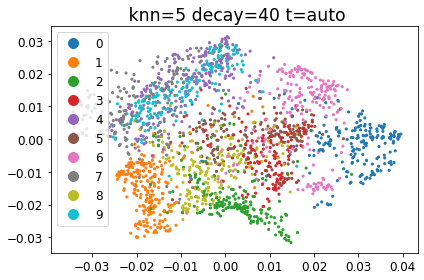

In [33]:
# show(Z,list(X1_labels)+list(X2_labels),title=f'phate n_filters={n_filters}')
show(np.concatenate([X1,X2],axis=0),list(X1_labels)+list(X2_labels))

/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/2922630334.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={40} t=auto",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

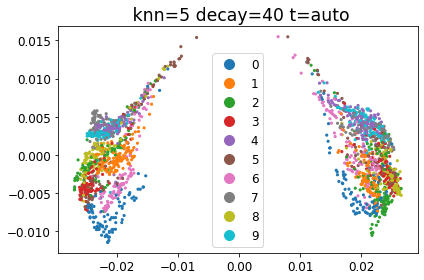

In [34]:
_ = show(np.concatenate([X1,X2_rotate],axis=0),list(X1_labels)+list(X2_labels))

/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/2922630334.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={40} t=auto",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

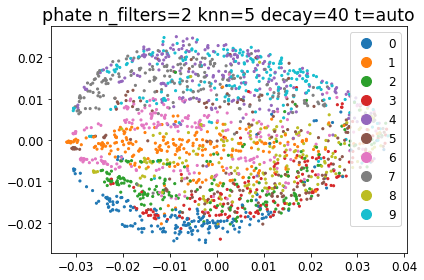

In [35]:
_=show(Z,list(X1_labels)+list(X2_labels),title=f'phate n_filters={n_filters}')

/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/1888428849.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={knn} decay={decay} t=auto gamma={1}",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

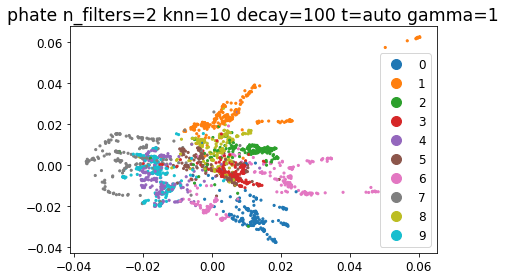

In [38]:
def show(X,labels,title='',decay=15, knn=5):
    plt.figure()
    phate_operator = phate.PHATE(verbose=0, decay=decay, knn=knn)
    tree_phate = phate_operator.fit_transform(X)
    phate.plot.scatter2d(tree_phate,title=f"{title} knn={knn} decay={decay} t=auto gamma={1}",c=labels)
    return tree_phate

_=show(Z,list(X1_labels)+list(X2_labels),title=f'phate n_filters={n_filters}', decay=100, knn=10)

LA.norm(X2)=75467.84456309852
LA.norm(X2_rotate)=77301.4961406714
np.sum((X2_rotate != X2)*1)=784000
Calculating eigendecomposition...
Calculated eigendecomposition in 2.07 seconds.


/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/519733098.py:36: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={15} t=auto gamma={1}",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/519733098.py:36: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={15} t=auto gamma={1}",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib

Calculating Harmonic Alignment...
  Calculating diffusion coordinates...
Calculating PCA...
Calculated PCA in 0.22 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.27 seconds.
Calculating PCA...
Calculated PCA in 0.12 seconds.
Calculating KNN search...
Calculated KNN search in 0.14 seconds.
Calculating affinities...
Calculated affinities in 0.05 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.26 seconds.
  Calculated diffusion coordinates in 1.45 seconds.
  Calculating wavelets...
  Calculated wavelets in 2.12 seconds.
  Calculating transformed data...
    Calculating graph Laplacian...
Calculating PCA...
Calculated PCA in 0.65 seconds.
Calculating KNN search...
Calculated KNN search in 0.48 seconds.
Calculating affinities...
Calculated affinities in 0.45 seconds.
    Calculated graph

/var/folders/4v/rml1wwps07b7b2qgflm7z0h00000gn/T/ipykernel_46577/519733098.py:36: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={15} t=auto gamma={1}",c=labels)
/usr/local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

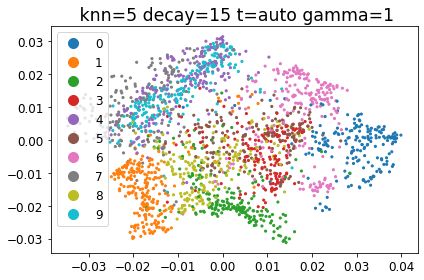

<Figure size 432x288 with 0 Axes>

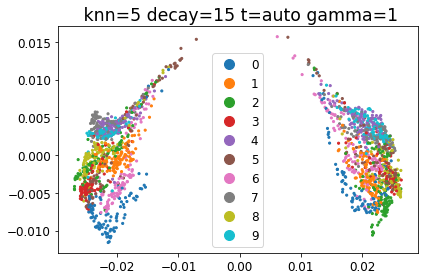

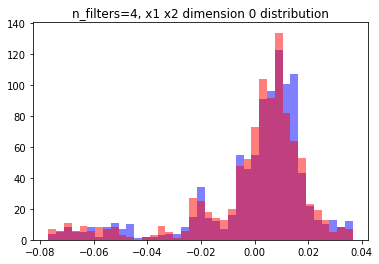

<Figure size 432x288 with 0 Axes>

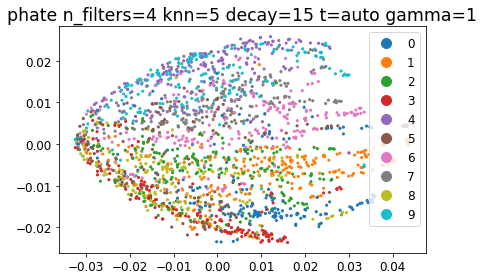

In [39]:
# we use this script in the paper to make the corruption experiment.
from sklearn import datasets, neighbors
from scipy import stats
import numpy as np
import harmonicalignment
import harmonicalignment.math
from shutil import copyfileobj
from six.moves import urllib
import os
import matplotlib.pyplot as plt
import phate

def knnclassifier(X, X_labels, Y, Y_labels, knn): #输出的是测试的准确率
    knn_op = neighbors.KNeighborsClassifier(knn)
    knn_op.fit(X, X_labels)
    return knn_op.score(Y, Y_labels)
def overlapRatio(x1,x2,title='before alignment',nthFeature=0):
    plt.figure()
    a = x1[:,nthFeature]
    b = x2[:,nthFeature]
    _max=max(max(a),max(b))
    _min=min(min(a),min(b))
    bins = np.arange(_min,_max,(_max-_min)/40)
    hist1=plt.hist(a,bins=bins,fc=(0, 0, 1, 0.5)) #np.arange(-2,2,0.1)
    # plt.figure()
    hist2=plt.hist(b,bins=bins,fc=(1, 0, 0, 0.5))
    plt.title(f"{title}, x1 x2 dimension 0 distribution")

    t = np.concatenate([np.expand_dims(hist1[0], axis=0) , np.expand_dims(hist2[0], axis=0)],axis=0)
    _overlapRatio = np.sum(np.min(t,axis=0)) / np.sum(hist1[0])
    return _overlapRatio
def show(X,labels,title=''):
    plt.figure()
    phate_operator = phate.PHATE(verbose=0)
    tree_phate = phate_operator.fit_transform(X)
    phate.plot.scatter2d(tree_phate,title=f"{title} knn={5} decay={15} t=auto gamma={1}",c=labels)
    return tree_phate
np.random.seed(42)
digits = datasets.fetch_openml("mnist_784")
labels = digits["target"]
# imgs = digits["data"]
imgs = np.asarray(digits["data"])

n_samples = 1000
n_features = 784
n_iters = 1
n_percentages = 3
n_wavelets = 4

colreplace_probs = np.linspace(0, 1, n_percentages) if n_percentages > 1 else [1]
# scale of wavelets(eg n_filters) to use 要使用的小波规模（例如n_filters）。
wavelet_scales = [2, 8, 16, 64]
# kernel params 内核参数
knn_1 = 20
decay_1 = 20
pca_1 = 100
knn_2 = knn_1
decay_2 = decay_1
pca_2 = pca_1
# Z = transformed
knn_transform = 10
decay_transform = 10
pca_transform = None
# diffusion time for final embedding 最终嵌入的扩散时间
diffusion_t = 1

output = np.zeros((n_percentages, n_iters, n_wavelets, 2))
# store metrics in here 在这里存储指标

# 在一系列的概率分布[0. , 0.5, 1. ]中选一个，使用这一个比例从总共的 784 的n_features的列 不进行旋转； 当pct=0的时候完全不正交旋转，当pct=1的时候所有行正交旋转。

p = 1 #for p in range(n_percentages): 
# build random matrix and replace prct of columns with I 构建随机矩阵，用I替换各列的prct
pct = colreplace_probs[p] # array([0. , 0.5, 1. ]) p=0,1,2
random_rotation = stats.ortho_group.rvs(n_features) # 返回一个随机的正交矩阵，从O(N) Haar分布（O(N)上唯一的均匀分布）抽取一个比例的列变成单位矩阵的对应列。
# random orthogonal rotation 随机正交旋转
colReplace = np.random.choice(
    n_features, np.floor(pct * n_features).astype(int), replace=False
)
random_rotation[:, colReplace] = np.eye(n_features)[:, colReplace] #只有 pct （百分值）的pixel的值没有被破坏。只有p%保留像素的损坏图像


iter_idx=0 # for iter_idx in range(n_iters):
#  sample two sets of digits from MNIST 从MNIST中抽取两组数字
sample_idx = np.random.choice(len(labels), n_samples * 2, replace=False)
X1_idx = sample_idx[:n_samples]
X2_idx = sample_idx[n_samples:]
#  slice the digits 分割数字
X1 = imgs[X1_idx, :]
X2 = imgs[X2_idx, :]
#  transform X2 转化X2
X2_rotate = X2 @ random_rotation.T # 这里的random_rotation 当pct=1的时候完全就是单位矩阵；当pct=10时候完全就是正交矩阵。当pct=（0，1）的时候是一个非正交矩阵。
import numpy.linalg as LA
print(f"LA.norm(X2)={LA.norm(X2)}")
print(f"LA.norm(X2_rotate)={LA.norm(X2_rotate)}")
print(f"np.sum((X2_rotate != X2)*1)={np.sum((X2_rotate != X2)*1)}")
X_combined = np.vstack([X1, X2_rotate])
U_combined, S_combined = harmonicalignment.math.diffusionCoordinates(
    X_combined, decay_1, knn_1, pca_1
) # 根据原始数据，构建graph，然后形成SVD，输出SVD的输出，也就是三个矩阵
# this is for evaluating unaligned data.  You can also plot this. 这是为评估不对齐的数据。 你也可以绘制这个。
#  slice the labels 切分标签
X1_labels = labels[X1_idx]
X2_labels = labels[X2_idx]

# 在原始的数据上进行phate
_ = show(np.concatenate([X1,X2],axis=0),list(X1_labels)+list(X2_labels))
# 在损坏的数据上进行phate
_ = show(np.concatenate([X1,X2_rotate],axis=0),list(X1_labels)+list(X2_labels))


combined_labels = np.concatenate([X1_labels, X2_labels])
#  run pca and classify 运行PCA并且分类
DM_combined = U_combined @ np.diag(np.exp(-S_combined)) # 对于 SVD 的输出的乘积就是 PCA 的结果
beforeprct = knnclassifier(
    DM_combined[:n_samples, :],
    X1_labels,
    DM_combined[n_samples:, :],
    X2_labels,
    5,
) # 对于 PCA 的结果进行knn分类，前1000个数据作为训练，后面的
# for scale_idx in range(n_wavelets):
n_filters = 4 #n_filters = wavelet_scales[scale_idx]
align_op = harmonicalignment.HarmonicAlignment(
    n_filters,
    t=diffusion_t, # 1
    overlap=n_filters,
    verbose=1,
    knn_X=knn_1, # 20
    knn_Y=knn_2, # 20
    knn_XY=knn_transform, # 10
    decay_X=decay_1, # 20
    decay_Y=decay_2, # 20
    decay_XY=decay_transform, # 10
    n_pca_X=pca_1, # 100
    n_pca_Y=pca_2, # 100
    n_pca_XY=pca_transform, # None
)
align_op.align(X1, X2_rotate)
Z = align_op.diffusion_map()
afterprct = knnclassifier(
    Z[:n_samples, :], X1_labels, Z[n_samples:, :], X2_labels, 5
)
xb1_aligned = Z[:n_samples, :]
xb2_aligned = Z[n_samples:, :]
print(f"beforeprct={beforeprct}")
print(f"afterprct={afterprct}")
_overlapRatio = overlapRatio(xb1_aligned,xb2_aligned,title=f'n_filters={n_filters}')
print(f"n_filters={n_filters}, overlapRatio={_overlapRatio}")
_=show(Z,list(X1_labels)+list(X2_labels),title=f'phate n_filters={n_filters}')

